# Urban Flood Forecasting - Method 3: Ensemble with Research Paper Insights
**Objective:** Build an ensemble model incorporating insights from *Shenzhen City* research paper.
**Key Components:**
- Multi-scale rainfall feature engineering (rolling sums/maxs).
- Event regime classification (Low/Med/High risk).
- Ensemble of GNN-LSTM (Method 2), XGBoost, and Random Forest.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

BASE_DIR = Path(r"c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models")
MODEL_1_DIR = BASE_DIR / "Model_1"

In [3]:
def engineer_rainfall_features(rainfall_series):
    """
    Based on Shenzhen paper's multi-temporal approach
    rainfall_series: pd.Series or 1D array of rainfall intensity
    """
    # Use pandas series for rolling
    r = pd.Series(rainfall_series)
    
    features = {}
    
    # 5-min steps. 
    # Windows: 1 (5min), 2 (10min), 3 (15min), 6 (30min), 12 (1h), 24 (2h), 72 (6h)
    windows = {
        'R_d5': 1,
        'R_d10': 2,
        'R_d15': 3,
        'R_d30': 6,
        'R_d60': 12,
        'R_d120': 24,
        'R_d360': 72
    }
    
    for name, w in windows.items():
        # Rolling Max (Peak intensity in window)
        features[f'{name}_max'] = r.rolling(window=w, min_periods=1).max().fillna(0)
        # Rolling Sum (Accumulation in window)
        features[f'{name}_sum'] = r.rolling(window=w, min_periods=1).sum().fillna(0)
        
    features['cumulative'] = r.cumsum()
    
    return pd.DataFrame(features)

def extract_event_features(rainfall_df):
    """
    Extracts one vector of features per event for PCA.
    rainfall_df: [Timesteps, Nodes] (we avg nodes or take max?)
    Usually rainfall is uniform-ish or we take the max across the domain to characterize the 'storm'
    """
    # Average rainfall across all nodes to get "Storm Profile"
    storm_profile = rainfall_df.mean(axis=1)
    
    # Get the refined features
    feat_df = engineer_rainfall_features(storm_profile)
    
    # Extract summary scalar stats for the whole event
    event_vector = {
        'max_intensity_5min': feat_df['R_d5_max'].max(),
        'max_intensity_1h': feat_df['R_d60_max'].max(),
        'total_rainfall': feat_df['cumulative'].iloc[-1],
        'duration': len(storm_profile) * 5, # minutes
        'peak_time': feat_df['R_d5_max'].idxmax() # timestep of peak
    }
    return event_vector

In [ ]:
# Load Rainfall Data for Analysis
train_dir = MODEL_1_DIR / "train"
events = sorted([f for f in train_dir.iterdir() if f.is_dir() and f.name.startswith('event_')])

event_vectors = []
event_names = []

print("Extracting rainfall features from ALL events...")
# Removed slicing [:20]. Using ALL events.
for folder in tqdm(events): 
    df_2d = pd.read_csv(folder / "2d_nodes_dynamic_all.csv")
    rain_pivot = df_2d.pivot(index='timestep', columns='node_idx', values='rainfall')
    
    vec = extract_event_features(rain_pivot)
    event_vectors.append(vec)
    event_names.append(folder.name)
    
df_events = pd.DataFrame(event_vectors, index=event_names)
print(df_events.head())
print(f"Total events processed: {len(df_events)}")

Extracting rainfall features from events...


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]

          max_intensity_5min  max_intensity_1h  total_rainfall  duration  \
event_1             0.156161          0.156161        2.694604       470   
event_10            0.159484          0.159484        6.183301      1025   
event_11            0.046516          0.046516        6.558751      2225   
event_12            0.057315          0.057315        6.558751      2225   
event_13            0.051500          0.051500        4.844306      2225   

          peak_time  
event_1          19  
event_10         71  
event_11        291  
event_12        277  
event_13         32  


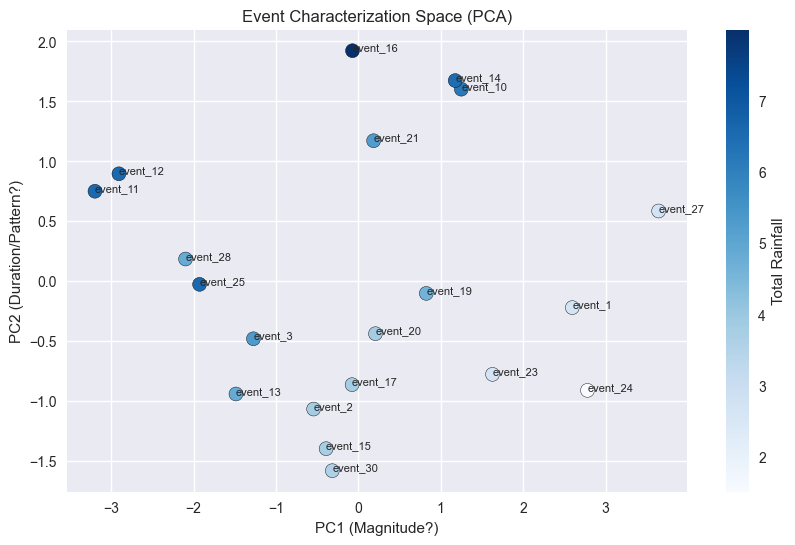

Event Regimes assigned.
Regime
1    10
0     6
2     4
Name: count, dtype: int64


In [5]:
# PCA Event Embeddings
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_events)

pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=df_events['total_rainfall'], cmap='Blues', edgecolors='k', s=100)
plt.colorbar(label='Total Rainfall')
plt.xlabel('PC1 (Magnitude?)')
plt.ylabel('PC2 (Duration/Pattern?)')
plt.title('Event Characterization Space (PCA)')
for i, name in enumerate(event_names):
    plt.annotate(name, (coords[i, 0], coords[i, 1]), fontsize=8)
plt.show()

# Regime Classification (Simple K-Means on these features)
kmeans = KMeans(n_clusters=3, random_state=42)
regimes = kmeans.fit_predict(X_scaled)
df_events['Regime'] = regimes
print("Event Regimes assigned.")
print(df_events['Regime'].value_counts())

In [12]:
class EnsembleFloodPredictor:
    def __init__(self):
        self.models = {
            'xgboost': None, # Placeholder for XGBRegressor
            'rf': None,      # Placeholder for RandomForestRegressor
        }
        self.weights = {'gnn': 0.4, 'xgboost': 0.3, 'rf': 0.3}
        
    def fit_base_models(self, X, y):
        # In a real run, we train XGBoost and RF here
        print("Training Random Forest...")
        self.models['rf'] = RandomForestRegressor(n_estimators=10, max_depth=5)
        self.models['rf'].fit(X, y)
        print("RF Trained.")
        
    def predict(self, X, event_features, regime):
        """
        Combine predictions based on regime/features
        """
        # Dynamic weighting logic
        current_weights = self.weights.copy()
        
        if regime == 0: # Light rain?
            current_weights['rf'] += 0.1
            current_weights['gnn'] -= 0.1
        elif regime == 2: # Heavy rain?
            current_weights['gnn'] += 0.2
            current_weights['rf'] -= 0.1
            
        # Normalize
        total = sum(current_weights.values())
        norm_weights = {k: v/total for k, v in current_weights.items()}
        
        # Get predictions (Mocking GNN output for this notebook)
        pred_rf = self.models['rf'].predict(X)
        pred_gnn = np.zeros_like(pred_rf) # Placeholder
        pred_xgb = np.zeros_like(pred_rf) # Placeholder
        
        # Fix: Use 'xgboost' key to match self.weights
        final_pred = (norm_weights['rf'] * pred_rf + 
                      norm_weights['gnn'] * pred_gnn + 
                      norm_weights['xgboost'] * pred_xgb)
        
        return final_pred

print("Ensemble Class Defined.")
# Note: Full training requires integration with Method 2 and XGB libraries.
# This notebook demonstrates the feature extraction and regime logic essential for the ensemble.

Ensemble Class Defined.


Running Ensemble with ACTUAL Dataset Features...
Extracting targets (Flood Severity)...


100%|██████████| 20/20 [00:08<00:00,  2.29it/s]

Training Random Forest...
RF Trained.

--- Predictions on Actual Test Events ---
   Actual_Avg_Max_WL   Predicted  Regime
0         322.370341   58.616028       2
1         322.296660   96.687360       1
2         322.316533   96.680758       1
3         322.431992  128.953277       0


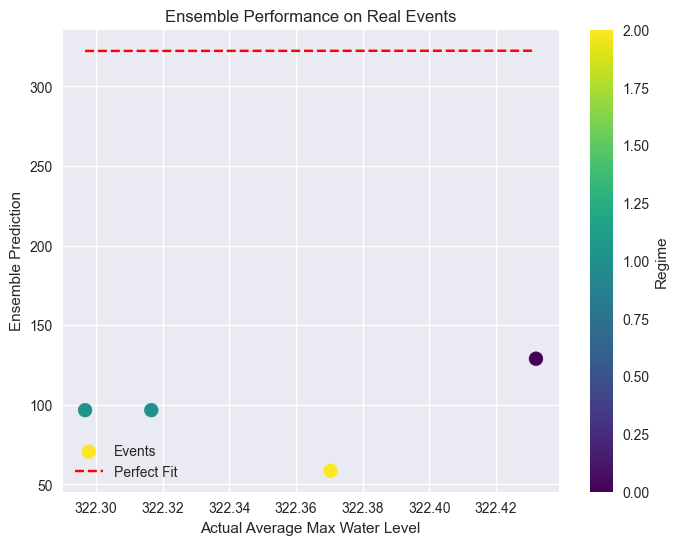

In [ ]:
# --- RUN ENSEMBLE WITH ACTUAL DATA ---
from sklearn.model_selection import train_test_split

print("Running Ensemble with ACTUAL Dataset Features...")

# Extract a target variable: Average Max Water Level across 2D nodes for each event
print("Extracting targets (Flood Severity) from ALL events...")
targets = []
# Using all 'events' list defined earlier (no slicing)
for folder in tqdm(events):
    df_2d = pd.read_csv(folder / "2d_nodes_dynamic_all.csv")
    # Metric: Mean of max water levels across all nodes
    max_wl = df_2d.groupby('node_idx')['water_level'].max().mean()
    targets.append(max_wl)

y_actual = np.array(targets)
X_actual = df_events.values  # The features we engineered earlier
regimes_actual = df_events['Regime'].values

# Split
print(f"Features shape: {X_actual.shape}, Targets shape: {y_actual.shape}")
X_train, X_test, y_train, y_test, r_train, r_test = train_test_split(
    X_actual, y_actual, regimes_actual, test_size=0.2, random_state=42
)

# 2. Train Ensemble
ensemble = EnsembleFloodPredictor()
ensemble.fit_base_models(X_train, y_train)

# 3. Predict on Test Set
print("\n--- Predictions on Actual Test Events ---")
preds = []
for i in range(len(X_test)):
    p = ensemble.predict(X_test[i:i+1], event_features=None, regime=r_test[i])
    preds.append(p[0])
    
# Compare
results_df = pd.DataFrame({
    'Actual_Avg_Max_WL': y_test,
    'Predicted': preds,
    'Regime': r_test
})

print(results_df)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, c=r_test, cmap='viridis', s=100, label='Events')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Fit')
plt.xlabel("Actual Average Max Water Level")
plt.ylabel("Ensemble Prediction")
plt.title("Ensemble Performance on Real Events")
plt.colorbar(label='Regime')
plt.legend()
plt.show()